# Assignment 2: Traffic Sign Detection

- **Student Name 1**: Antón Aba
- **Student Name 2**: Arturo Pinar
- **Student Name 3**: Ignacio Regaña

The assignments should be done in groups of three people. Please write your names and emails in the above list now. 

In this assignment you have to solve an traffic sign detection problem. To this end you must improve the provided Faster R-CNN network introducing your own modifications. 

We provide an implementation of:

> S. Ren, K. He, R. Girshick and J. Sun, "Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 39, no. 6, pp. 1137-1149, 1 June 2017.

Using ResNet50 as backbone. We provide the pre-trained weights of both, the backbone and the region proposal network. We also provide the code to download and use [The German Traffic Sign Detection Benchmark](https://benchmark.ini.rub.de/gtsdb_news.html), that defines the traffic sign detection problem to solve.

To promote good results, we have created a challenge called "The traffic sign detection challenge 2021" where you must publish every good result that you obtain (keep in mind that the position in these competitions will determine 10% of your grade in this unit).

The deadline of the assignment is April 5th,  before 23:55. In this deadline you should provide:
- **Source code of this Assignment 2** (Python notebook in format .ipynb)
- **Source code of Assignment 1**, which you are free to modify to improve the results. (Python notebook in format .ipynb)
- **A document in .PDF format** explaining the design decisions made on both tasks. This document should also draw all the conclusions and valuable things that you have learnt in this part of the course.


Before submitting the code, please ensure that all your notebook cells can be correctly executed from scratch. To do so, you can click in "Kernel" > "Restart and Run All".

## German Traffic Sign Detection Benchmark

Download full data set from http://www.dia.fi.upm.es/~lbaumela/FullIJCNN2013.zip

In [ ]:
!wget -nc http://www.dia.fi.upm.es/~lbaumela/FullIJCNN2013.zip
!unzip -q FullIJCNN2013.zip

--2021-04-04 12:03:24--  http://www.dia.fi.upm.es/~lbaumela/FullIJCNN2013.zip
Resolving www.dia.fi.upm.es (www.dia.fi.upm.es)... 138.100.11.29
Connecting to www.dia.fi.upm.es (www.dia.fi.upm.es)|138.100.11.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1661866983 (1.5G) [application/zip]
Saving to: ‘FullIJCNN2013.zip’

FullIJCNN2013.zip   100%[===================>]   1.55G  9.55MB/s    in 2m 49s  

2021-04-04 12:06:14 (9.39 MB/s) - ‘FullIJCNN2013.zip’ saved [1661866983/1661866983]



In [ ]:
!wget -c http://www.dia.fi.upm.es/~lbaumela/weights_objects.h5

--2021-04-04 12:08:10--  http://www.dia.fi.upm.es/~lbaumela/weights_objects.h5
Resolving www.dia.fi.upm.es (www.dia.fi.upm.es)... 138.100.11.29
Connecting to www.dia.fi.upm.es (www.dia.fi.upm.es)|138.100.11.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151961224 (145M)
Saving to: ‘weights_objects.h5’

weights_objects.h5  100%[===================>] 144.92M  9.50MB/s    in 17s     

2021-04-04 12:08:28 (8.49 MB/s) - ‘weights_objects.h5’ saved [151961224/151961224]



In [ ]:
# Download the evaluation repository
!rm -rf mAP
!git clone https://github.com/Cartucho/mAP.git
! cd mAP && git checkout 92e6d334c903ab795fdae15d1a45730d768b4c08 && cd ..
# Create the directories
!rm -rf mAP/input/ground-truth
!mkdir -p mAP/input/ground-truth
!rm -rf mAP/input/detection-results
!mkdir -p mAP/input/detection-results

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 21.74 MiB/s, done.
Resolving deltas: 100% (321/321), done.
Note: checking out '92e6d334c903ab795fdae15d1a45730d768b4c08'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 92e6d33 Merge branch 'NH1922-master'


In [ ]:
#!pip install opencv-python
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [ ]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

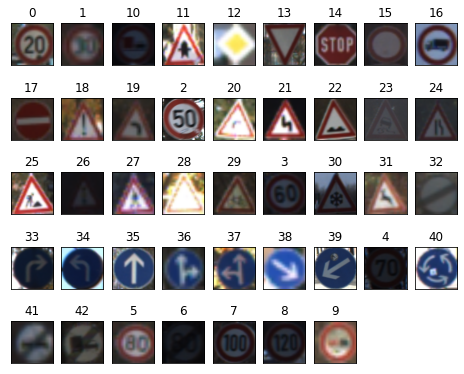

In [ ]:
#!pip install matplotlib

import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

### Data Augmentation

#### Data Augmentation Process

In [ ]:
def generate_fake_images(real_image, label, datagen, train_signs, train_labels):
   
    it = datagen.flow(real_image, batch_size = 1)
    for change in range(1):
        batch = it.next()
        img_new = batch[0].astype('uint8')
        
        train_signs.append(img_new)
        train_labels.append(label)
       
    return train_signs, train_labels

In [ ]:
#!pip install sklearn
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from numpy import expand_dims

# trial and error found values
datagens = [
    ImageDataGenerator(width_shift_range =[-50, 50]),
    ImageDataGenerator(height_shift_range = 0.4),
    ImageDataGenerator(rotation_range = 45),
    ImageDataGenerator(brightness_range = [0.5, 1.0]),
    ImageDataGenerator(zoom_range = [0.7, 1.0])
]

train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)

length = len(train_signs)
for i in range (length): 
    aux = train_signs[i]
    img = expand_dims(aux, 0)
    label = train_labels[i]
    
    for datagen in datagens:
    # Width augmentation
        train_signs, train_labels = generate_fake_images(img, label, datagen, train_signs, train_labels)

In [ ]:
# Split training and validation
#!pip install sklearn

from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

va_signs = np.array(train_signs)[3500:]
va_labels = np.array(train_labels)[3500:]

train_signs = train_signs[:3500]
train_labels = train_labels[:3500]

#### Number of signs after data augmentation

In [ ]:
print("len train_signs: ", len(train_signs))
print("len train labels: ", len(train_labels))

print("len va_signs: ", len(va_signs))
print("len va_labels: ", len(va_labels))

len train_signs:  3500
len train labels:  3500
len va_signs:  1612
len va_labels:  1612


### Data Preprocessing

In [ ]:
#!pip install sklearn

from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

# Randomization of data augmented
train_signs, train_labels = shuffle(train_signs, train_labels)
tr_signs = np.array(train_signs)
tr_labels = np.array(train_labels)

te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

tr_labels = to_categorical(tr_labels, num_classes)
va_labels = to_categorical(va_labels, num_classes)
te_labels = to_categorical(te_labels, num_classes)

## CNN improvement

In [ ]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from time import time
from tensorflow.keras.callbacks import EarlyStopping


input_shape = (SIGN_SIZE[0], SIGN_SIZE[1], 3)

cnn = Sequential()

cnn.add(Conv2D(8, kernel_size=(3, 3), padding='same', input_shape=input_shape))
cnn.add(Activation('relu'))

cnn.add(Conv2D(16, strides=(2, 2), kernel_size=(3, 3), padding='same'))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.5))

cnn.add(Conv2D(32, strides=(2, 2), kernel_size=(3, 3), padding='same'))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.5))

cnn.add(Flatten())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.5))

cnn.add(Dense(num_classes))
cnn.add(Activation('softmax'))

opt = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cnn.summary()

callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
cnn.fit(tr_signs, tr_labels,
        batch_size=50,
        epochs=2000,
        verbose=2,
        callbacks = [callback],
        validation_data=(va_signs, va_labels))



loss, acc = cnn.evaluate(te_signs, te_labels, verbose=1)

print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

cnn.save("model2.h5")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 8)       224       
_________________________________________________________________
activation_95 (Activation)   (None, 224, 224, 8)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 16)      1168      
_________________________________________________________________
activation_96 (Activation)   (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 32)        4640      
_________________________________________________________________
activation_97 (Activation)   (None, 56, 56, 32)       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3500/3500 - 4s - loss: 3.4141 - acc: 0.1111 - val_loss: 3.1645 - val_acc: 0.2233
Epoch 2/2000
3500/3500 - 3s - loss: 2.8330 - acc: 0.2629 - val_loss: 2.6066 - val_acc: 0.3133
Epoch 3/2000
3500/3500 - 3s - loss: 2.2904 - acc: 0.3777 - val_loss: 2.3398 - val_acc: 0.3666
Epoch 4/2000
3500/3500 - 3s - loss: 1.9487 - acc: 0.4403 - val_loss: 2.1789 - val_acc: 0.4113
Epoch 5/2000
3500/3500 - 3s - loss: 1.7602 - acc: 0.4957 - val_loss: 2.1119 - val_acc: 0.4318
Epoch 6/2000
3500/3500 - 3s - loss: 1.5894 - acc: 0.5377 - val_loss: 2.0395 - val_acc: 0.4646
Epoch 7/2000
3500/3500 - 3s - loss: 1.4521 - acc: 0.5771 - val_loss: 2.0246 - val_acc: 0.4634
Epoch 8/2000
3500/3500 - 3s - loss: 1.3567 - acc: 0.6020 - val_loss: 1.8973 - val_acc: 0.5068
Epoch 9/2000
3500/3500 - 3s - loss: 1.2364 - acc: 0.6403 - val_loss: 1.8762 - val_acc: 0.4913
Epoch 10/2000
3500/3500 - 3s - loss: 1.1586 - acc: 0.6640 - val_loss: 1.8244 - val_acc: 0.5354
Epoch 11/2000
3500/3500 - 3s - loss: 1.0974 - acc: 0.6749 - val_loss: 1.

## Region proposal network

In [ ]:
ANCHOR_RATIOS = (0.5, 1.0, 2.0)
ANCHOR_STRIDE = 16
ANCHOR_SIZES = (32, 64, 128, 256, 512)
MAX_SIZE = 1344
MIN_SIZE = 10

# Parameters to play with to modify the number of proposal in each image
TEST_PRE_NMS_TOPK = 8000 # The maximum number of positive samples taken during proposal generation, pre NMS
TEST_POST_NMS_TOPK = 1000 # The maximum number of positive samples taken during proposal generation, post NMS
PROPOSAL_NMS_THRESH = 0.85

In [ ]:
"""Operations for [N, 4] numpy arrays representing bounding boxes.
Example box operations that are supported:
  * Areas: compute bounding box areas
  * IOU: pairwise intersection-over-union scores
"""
def area(boxes):
    """Computes area of boxes.
    Args:
    boxes: Numpy array with shape [N, 4] holding N boxes
    Returns:
    a numpy array with shape [N*1] representing box areas
    """
    return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

def intersection(boxes1, boxes2):
    """Compute pairwise intersection areas between boxes.
    Args:
    boxes1: a numpy array with shape [N, 4] holding N boxes
    boxes2: a numpy array with shape [M, 4] holding M boxes
    Returns:
    a numpy array with shape [N*M] representing pairwise intersection area
    """
    [x_min1, y_min1, x_max1, y_max1] = np.split(boxes1, 4, axis=1)
    [x_min2, y_min2, x_max2, y_max2] = np.split(boxes2, 4, axis=1)
    all_pairs_min_ymax = np.minimum(y_max1, np.transpose(y_max2))
    all_pairs_max_ymin = np.maximum(y_min1, np.transpose(y_min2))
    intersect_heights = np.maximum(np.zeros(all_pairs_max_ymin.shape, dtype='f4'),all_pairs_min_ymax - all_pairs_max_ymin)
    all_pairs_min_xmax = np.minimum(x_max1, np.transpose(x_max2))
    all_pairs_max_xmin = np.maximum(x_min1, np.transpose(x_min2))
    intersect_widths = np.maximum(np.zeros(all_pairs_max_xmin.shape, dtype='f4'),all_pairs_min_xmax - all_pairs_max_xmin)
    return intersect_heights * intersect_widths

def iou(boxes1, boxes2):
    """Computes pairwise intersection-over-union between box collections.
    Args:
    boxes1: a numpy array with shape [N, 4] holding N boxes.
    boxes2: a numpy array with shape [M, 4] holding M boxes.
    Returns:
    a numpy array with shape [N, M] representing pairwise iou scores.
    """
    intersect = intersection(boxes1, boxes2)
    area1 = area(boxes1)
    area2 = area(boxes2)
    union = np.expand_dims(area1, axis=1) + np.expand_dims(area2, axis=0) - intersect
    return intersect / union

def ioa(boxes1, boxes2):
    """Computes pairwise intersection-over-area between box collections.
    Intersection-over-area (ioa) between two boxes box1 and box2 is defined as
    their intersection area over box2's area. Note that ioa is not symmetric,
    that is, IOA(box1, box2) != IOA(box2, box1).
    Args:
    boxes1: a numpy array with shape [N, 4] holding N boxes.
    boxes2: a numpy array with shape [M, 4] holding N boxes.
    Returns:
    a numpy array with shape [N, M] representing pairwise ioa scores.
    """
    intersect = intersection(boxes1, boxes2)
    inv_areas = np.expand_dims(1.0 / area(boxes2), axis=0)
    return intersect * inv_areas

def clip_boxes(bboxes, clip_box, alpha):
    """
    This function clip the bboxes to the border of the image

    :param bboxes: array of shape (Nx4) containing the coordinates of the bboxes
                in the format: xmin, ymin, xmax, ymax.
    :param clip_box: array of shape (4,) containing the coordinates of the image
                in the format: xmin, ymin, xmax ymax.
    :param alpha:float, minimum threshold of area acepted. If a clipped bbpx
                    have an relative area (wrt their original area) less than
                    alpha, it is discarded.
    :return: numpy array Nx4 of the clipped bboxes with their new coordinates
            in the format xmin, ymin, xmax, ymax.
    """
    areas = area(bboxes)
    bboxes[:, 0] = np.maximum(bboxes[:, 0], clip_box[0])
    bboxes[:, 1] = np.maximum(bboxes[:, 1], clip_box[1])
    bboxes[:, 2] = np.minimum(bboxes[:, 2], clip_box[2])
    bboxes[:, 3] = np.minimum(bboxes[:, 3], clip_box[3])
    new_areas = area(bboxes)
    delta_area = (areas - new_areas) / areas
    mask = np.where(delta_area < 1 - alpha)
    bboxes = bboxes[mask[0]]
    return bboxes

In [ ]:
import tensorflow.compat.v1 as tf1
import tensorflow as tf

tf1.disable_v2_behavior()


def generate_anchors(base_size=16, ratios=[0.5, 1, 2], scales=2**np.arange(3, 6)):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales wrt a reference (0, 0, 15, 15) window.
    """
    base_anchor = np.array([1, 1, base_size, base_size], dtype='float32') - 1
    ratio_anchors = _ratio_enum(base_anchor, ratios)
    anchors = np.vstack([_scale_enum(ratio_anchors[i, :], scales) for i in range(ratio_anchors.shape[0])])
    return anchors

def _whctrs(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    """
    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr

def _mkanchors(ws, hs, x_ctr, y_ctr):
    """
    Given a vector of widths (ws) and heights (hs) around a center
    (x_ctr, y_ctr), output a set of anchors (windows).
    """
    ws = ws[:, np.newaxis]
    hs = hs[:, np.newaxis]
    anchors = np.hstack((x_ctr - 0.5 * (ws - 1), y_ctr - 0.5 * (hs - 1), x_ctr + 0.5 * (ws - 1), y_ctr + 0.5 * (hs - 1)))
    return anchors

def _ratio_enum(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """
    w, h, x_ctr, y_ctr = _whctrs(anchor)
    size = w * h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

def _scale_enum(anchor, scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    """
    w, h, x_ctr, y_ctr = _whctrs(anchor)
    ws = w * scales
    hs = h * scales
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

def get_all_anchors(stride=None, sizes=None):
    """
    Get all anchors in the largest possible image, shifted, floatbox
    Args:
        stride (int): the stride of anchors.
        sizes (tuple[int]): the sizes (sqrt area) of anchors

    Returns:
        anchors: SxSxNUM_ANCHORx4, where S == ceil(MAX_SIZE/STRIDE), floatbox
        The layout in the NUM_ANCHOR dim is NUM_RATIO x NUM_SIZE.

    """
    if stride is None:
        stride = ANCHOR_STRIDE
    if sizes is None:
        sizes = ANCHOR_SIZES
    # Generates a NAx4 matrix of anchor boxes in (x1, y1, x2, y2) format. Anchors
    # are centered on stride / 2, have (approximate) sqrt areas of the specified
    # sizes, and aspect ratios as given.
    cell_anchors = generate_anchors(stride, scales=np.array(sizes, dtype=np.float) / stride, ratios=np.array(ANCHOR_RATIOS, dtype=np.float))
    # anchors are intbox here.
    # anchors at featuremap [0,0] are centered at fpcoor (8,8) (half of stride)
    field_size = int(np.ceil(MAX_SIZE / stride))
    shifts = np.arange(0, field_size) * stride
    shift_x, shift_y = np.meshgrid(shifts, shifts)
    shift_x = shift_x.flatten()
    shift_y = shift_y.flatten()
    shifts = np.vstack((shift_x, shift_y, shift_x, shift_y)).transpose()
    K = shifts.shape[0]

    A = cell_anchors.shape[0]
    field_of_anchors = (
        cell_anchors.reshape((1, A, 4)) +
        shifts.reshape((1, K, 4)).transpose((1, 0, 2)))
    field_of_anchors = field_of_anchors.reshape((field_size, field_size, A, 4))
    field_of_anchors = field_of_anchors.astype('float32')
    field_of_anchors[:, :, :, [2, 3]] += 1
    return field_of_anchors

def decode_bbox_target(box_predictions, anchors):
    """
    Args:
        box_predictions: (..., 4), logits
        anchors: (..., 4), floatbox. Must have the same shape

    Returns:
        box_decoded: (..., 4), float32. With the same shape.
    """
    orig_shape = tf.shape(anchors)
    box_pred_txtytwth = tf.reshape(box_predictions, (-1, 2, 2))
    box_pred_txty, box_pred_twth = tf.split(box_pred_txtytwth, 2, axis=1)
    anchors_x1y1x2y2 = tf.reshape(anchors, (-1, 2, 2))
    anchors_x1y1, anchors_x2y2 = tf.split(anchors_x1y1x2y2, 2, axis=1)

    waha = anchors_x2y2 - anchors_x1y1
    xaya = (anchors_x2y2 + anchors_x1y1) * 0.5
    clip = np.log(MAX_SIZE / 16.)
    wbhb = tf.exp(tf.minimum(box_pred_twth, clip)) * waha
    xbyb = box_pred_txty * waha + xaya
    x1y1 = xbyb - wbhb * 0.5
    x2y2 = xbyb + wbhb * 0.5
    out = tf.concat([x1y1, x2y2], axis=-2)
    return tf.reshape(out, orig_shape)

def narrow_to_c4(featuremaps, anchor_boxes):
    """
    Slice anchors to the spatial size of this featuremap.
    """
    shape2d = tf.shape(featuremaps)[2:]  # h,w
    slice4d = tf.concat([shape2d, [-1, -1]], axis=0)
    anchor_boxes = tf.slice(anchor_boxes, [0, 0, 0, 0], slice4d)
    return anchor_boxes

def clip_boxes(boxes, window, name=None):
    """
    Args:
        boxes: nx4, xyxy
        window: [h, w]
    """
    boxes = tf.maximum(boxes, 0.0)
    m = tf.tile(tf.reverse(window, [0]), [2])  # (4,)
    boxes = tf.minimum(boxes, tf1.to_float(m), name=name)
    return boxes

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
def generate_rpn_proposals(boxes_and_scores, img_shape, pre_nms_topk, post_nms_topk):
    """
    Sample RPN proposals by the following steps:
    1. Pick top k1 by scores
    2. NMS them
    3. Pick top k2 by scores. Default k2 == k1, i.e. does not filter the NMS output.

    Args:
        boxes: nx4 float dtype, the proposal boxes. Decoded to floatbox already
        scores: n float, the logits
        img_shape: [h, w]
        pre_nms_topk, post_nms_topk (int): See above.

    Returns:
        boxes: kx4 float
        scores: k logits
    """
    boxes = boxes_and_scores[0]
    scores = boxes_and_scores[1]

    assert boxes.shape.ndims == 2, boxes.shape
    if post_nms_topk is None:
        post_nms_topk = pre_nms_topk

    topk = tf.minimum(pre_nms_topk, tf.size(scores))
    topk_scores, topk_indices = tf.nn.top_k(scores, k=topk, sorted=False)
    topk_boxes = tf.gather(boxes, topk_indices)
    topk_boxes = clip_boxes(topk_boxes, img_shape)

    topk_boxes_x1y1x2y2 = tf.reshape(topk_boxes, (-1, 2, 2))
    topk_boxes_x1y1, topk_boxes_x2y2 = tf.split(topk_boxes_x1y1x2y2, 2, axis=1)

    #################################################################
    #TODO: You can implement here some filtering strategy to select the best bounding boxes. For example:
    diag = tf.constant([[1,1]], dtype = tf.float32)
    diagonal = tf.reshape(diag, (-1, 1, 2))
    
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
    
    similarity = cosine_loss(topk_boxes_x2y2 - topk_boxes_x1y1, diagonal)
    
    wbhb = tf.squeeze(topk_boxes_x2y2 - topk_boxes_x1y1, axis=1)
    valid = tf.reduce_all( (wbhb > MIN_SIZE) & (similarity<-0.95), axis=1)
    
    #################################################################
    
    topk_valid_boxes_x1y1x2y2 = tf.boolean_mask(topk_boxes_x1y1x2y2, valid)
    topk_valid_scores = tf.boolean_mask(topk_scores, valid)

    topk_valid_boxes_y1x1y2x2 = tf.reshape(tf.reverse(topk_valid_boxes_x1y1x2y2, axis=[2]), (-1, 4), name='nms_input_boxes')
    nms_indices = tf.image.non_max_suppression(topk_valid_boxes_y1x1y2x2, topk_valid_scores, max_output_size=post_nms_topk, iou_threshold=PROPOSAL_NMS_THRESH)

    topk_valid_boxes = tf.reshape(topk_valid_boxes_x1y1x2y2, (-1, 4))
    proposal_boxes = tf.gather(topk_valid_boxes, nms_indices)
    proposal_scores = tf.gather(topk_valid_scores, nms_indices)
    return [tf.stop_gradient(proposal_boxes, name='boxes'), tf.stop_gradient(proposal_scores, name='scores')]

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D, Input, Activation, Lambda
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, ZeroPadding2D, Add
from tensorflow.keras.models import Model

def resnet_layer(inputs, name, kernel_size=(1,1), num_filters=64, stride=1, padding='same', activation=True, batch_normalization=True):
    conv = Conv2D(kernel_size=kernel_size, filters=num_filters, strides=stride, padding=padding, use_bias=False, name='C' + name, data_format='channels_first')
    x = conv(inputs)
    if batch_normalization == True:
        x = BatchNormalization(name='bn' + name, axis=1)(x)
    if activation == True:
        x = Activation('relu')(x)
    return x

def residual_block(inputs, name, kernel_size=(1,1), stride=1, num_filters=64, shortcut_connection=False, first_stage=False):
    num_filters_out = num_filters * 4
    z = inputs
    if shortcut_connection == True:
        if first_stage == True:
            stride = 1
        else:
            stride = 2
            z = Lambda(lambda x: x[:, :, :-1, :-1], name=name + 'shortcut_slice')(inputs)
        y = resnet_layer(z, kernel_size=kernel_size, num_filters=num_filters_out, stride=stride, activation=False, batch_normalization=True, name=name + '3')
    else:
        y = z

    x = resnet_layer(inputs, kernel_size=kernel_size, num_filters=num_filters, stride=1, name=name + '0')
    if stride == 2:
        x = ZeroPadding2D(padding=((1, 0), (1, 0)), data_format='channels_first')(x)
        x = resnet_layer(x, kernel_size=(3,3), num_filters=num_filters, stride=stride, padding='valid', name=name + '1')
    else:
        x = resnet_layer(x, kernel_size=(3,3), num_filters=num_filters, stride=stride, name=name + '1')
    x = resnet_layer(x, kernel_size=kernel_size, num_filters=num_filters_out, stride=1, activation=False, name=name + '2')
    sumed = Add()([x, y])
    out = Activation('relu')(sumed)
    return out

def resnet50_c4(inputs):
    blocks_per_stage = {0: 3, 1: 4, 2: 6}
    num_filters = 64
    x = ZeroPadding2D(padding=((3, 2), (3, 2)), data_format='channels_first')(inputs)
    x = resnet_layer(inputs=x, kernel_size=(7,7), stride=2, padding='valid', name='1_bl0_0')
    x = ZeroPadding2D(padding=((1, 0), (1, 0)), data_format='channels_first')(x)
    x = MaxPooling2D((3,3), strides=2, padding='valid', name='maxpool', data_format='channels_first')(x)

    c234 = []
    for stage in range(3):
        first_stage = False if stage != 0 else True
        num_blocks = blocks_per_stage[stage]
        for block in range(num_blocks):
            shortcut_connection = False if block != 0 else True
            basename = str(stage+2) + '_bl' + str(block) + '_'
            x = residual_block(x, num_filters=num_filters, shortcut_connection=shortcut_connection, first_stage=first_stage, name=basename)
        c234.append(x)
        num_filters *= 2
    return c234

def rpn_head(c4):
    conv_0 = Conv2D(kernel_size=(3,3), filters=1024, strides=1, padding='same', name='rpn_conv0', activation='relu', data_format='channels_first')(c4)
    label_logits = Conv2D(kernel_size=(1,1), filters=15, strides=1, padding='same', name='trainable/rpn_class', data_format='channels_first')(conv_0)
    box_logits = Conv2D(kernel_size=(1,1), filters=60, strides=1, padding='same', name='trainable/rpn_box', data_format='channels_first')(conv_0)
    label_logits = Lambda(lambda x: tf.transpose(x, [0, 2, 3, 1]))(label_logits)
    label_logits = Lambda(lambda x: tf.squeeze(x, 0))(label_logits)
    shape = tf.shape(box_logits)
    box_logits = Lambda(lambda x: tf.transpose(x, [0, 2, 3, 1]))(box_logits)
    box_logits = Lambda(lambda x: tf.reshape(x, tf.stack([shape[2], shape[3], 15, 4])))(box_logits)
    return [label_logits, box_logits]

def build_model(input):
    inputs = Input(tensor=input)
    c2, c3, c4 = resnet50_c4(inputs)

    # Object Detection
    rpn_label_logits, rpn_box_logits = rpn_head(c4)
    anchors = Lambda(narrow_to_c4, arguments={'anchor_boxes': get_all_anchors()})(c4)
    image_shape2d = tf.shape(input)[2:]
    pred_boxes_decoded = Lambda(decode_bbox_target, arguments={'anchors': anchors})(rpn_box_logits)
    pred_boxes_decoded = Lambda(lambda x: tf.reshape(x, [-1, 4]))(pred_boxes_decoded)
    rpn_label_logits = Lambda(lambda x: tf.reshape(x, [-1]))(rpn_label_logits)
    proposal_boxes, proposal_scores = Lambda(generate_rpn_proposals, arguments={'img_shape': image_shape2d, 'pre_nms_topk': TEST_PRE_NMS_TOPK, 'post_nms_topk': TEST_POST_NMS_TOPK}, name='proposals')([pred_boxes_decoded, rpn_label_logits])
    model = Model(inputs=inputs, outputs=[proposal_boxes, proposal_scores])
    return model

input = tf1.placeholder(tf.float32, shape=(1,3,None,None))
model = build_model(input)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(1, 3, None, None)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_16 (ZeroPadding2 (1, 3, None, None)   0           input_5[0][0]                    
__________________________________________________________________________________________________
C1_bl0_0 (Conv2D)               (1, 64, None, None)  9408        zero_padding2d_16[0][0]          
__________________________________________________________________________________________________
bn1_bl0_0 (BatchNormalization)  (1, 64, None, None)  256         C1_bl0_0[0][0]                   
____________________________________________________________________________________________

In [ ]:
import tensorflow as tf

def normalize_image(img, mean, std):
    mean = mean[::-1]
    std = std[::-1]
    new_img = (img - mean) / std
    new_img = np.transpose(new_img, (2, 0, 1))
    new_img = new_img[np.newaxis, :]
    return new_img

sess = tf1.Session()
# K.set_session(sess)

# Defining the graph
input = tf1.placeholder(tf.float32, shape=(1, 3, None, None))
model = build_model(input)
proposal_boxes, proposal_scores = model(input)

PIXEL_MEAN = [123.675, 116.28, 103.53]
PIXEL_STD = [58.395, 57.12, 57.375]

with sess.as_default():
    model.load_weights('weights_objects.h5', by_name=True)
    print('*** Training images ***')
    train_pred = {}
    for filename in train_images:
        print(filename)
        normalized_img = normalize_image(train_images.get(filename)[0], mean=PIXEL_MEAN, std=PIXEL_STD)
        bboxes, scores = sess.run([proposal_boxes, proposal_scores], feed_dict={input: normalized_img})
        train_pred.setdefault(filename,[]).append(bboxes)
    print('*** Testing images ***')
    test_pred = {}
    for filename in test_images:
        print(filename)
        normalized_img = normalize_image(test_images.get(filename)[0], mean=PIXEL_MEAN, std=PIXEL_STD)
        bboxes, scores = sess.run([proposal_boxes, proposal_scores], feed_dict={input: normalized_img})
        test_pred.setdefault(filename,[]).append(bboxes)

*** Training images ***
FullIJCNN2013/00000.ppm
FullIJCNN2013/00001.ppm
FullIJCNN2013/00002.ppm
FullIJCNN2013/00003.ppm
FullIJCNN2013/00004.ppm
FullIJCNN2013/00005.ppm
FullIJCNN2013/00006.ppm
FullIJCNN2013/00007.ppm
FullIJCNN2013/00008.ppm
FullIJCNN2013/00009.ppm
FullIJCNN2013/00010.ppm
FullIJCNN2013/00011.ppm
FullIJCNN2013/00012.ppm
FullIJCNN2013/00013.ppm
FullIJCNN2013/00014.ppm
FullIJCNN2013/00015.ppm
FullIJCNN2013/00016.ppm
FullIJCNN2013/00017.ppm
FullIJCNN2013/00018.ppm
FullIJCNN2013/00019.ppm
FullIJCNN2013/00020.ppm
FullIJCNN2013/00021.ppm
FullIJCNN2013/00022.ppm
FullIJCNN2013/00023.ppm
FullIJCNN2013/00024.ppm
FullIJCNN2013/00025.ppm
FullIJCNN2013/00026.ppm
FullIJCNN2013/00027.ppm
FullIJCNN2013/00028.ppm
FullIJCNN2013/00029.ppm
FullIJCNN2013/00030.ppm
FullIJCNN2013/00031.ppm
FullIJCNN2013/00032.ppm
FullIJCNN2013/00033.ppm
FullIJCNN2013/00034.ppm
FullIJCNN2013/00035.ppm
FullIJCNN2013/00036.ppm
FullIJCNN2013/00037.ppm
FullIJCNN2013/00038.ppm
FullIJCNN2013/00039.ppm
FullIJCNN2013/00

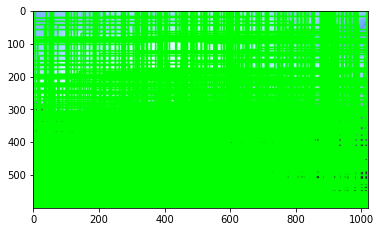

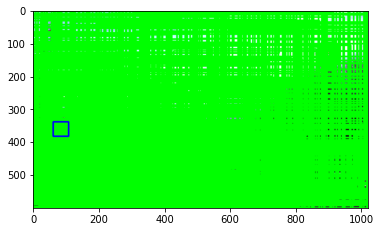

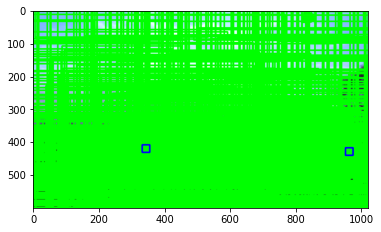

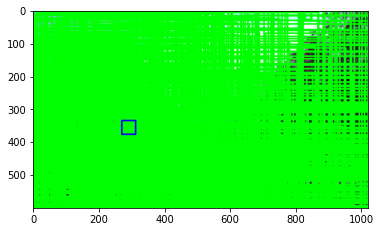

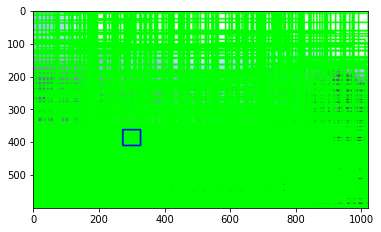

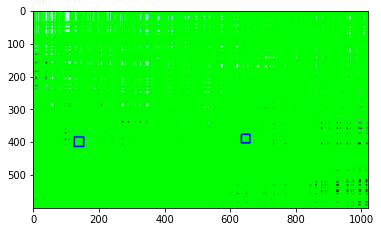

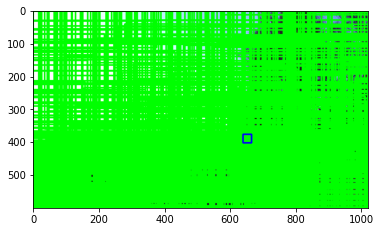

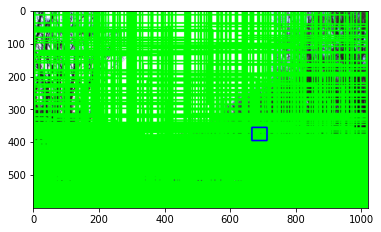

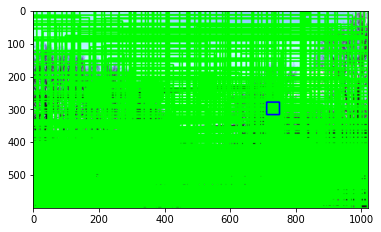

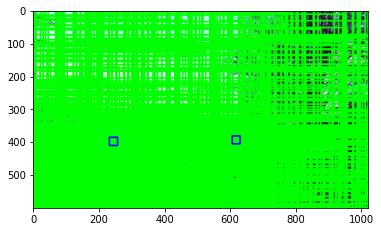

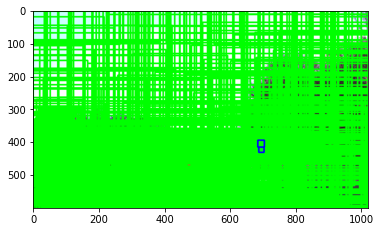

In [ ]:
counter = 0
for filename in test_images:
    # Draw predictions
    aux = test_images.get(filename)[0].copy()
    for bbox in test_pred.get(filename)[0]:
        cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (0,255,0), 3)
    # Draw ground truth
    if filename in test_files:
        for idx in [i for i, x in enumerate(test_files) if x == filename]:
            bbox = test_bboxes[idx]
            cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (255,0,0), 3)
    plt.imshow(cv2.cvtColor(aux, cv2.COLOR_BGR2RGB))
    plt.show()
    counter += 1
    if counter > 10:
        break

# Traffic Sign detection

We suggest you train a “detector” CNN that determines whether a region proposal is a
traffic sign. Then use your traffic sign classification net to obtain the actual class. This is
not the only approach to the problem, perhaps not even a good one. Feel free to follow
your own thoughts. Bear in mind that both accuracy, in terms of mAP, and running time
should be optimized in your solution. So, ideas to improve your classification performance
or speed-up the detection process, e.g. , e.g. use non-maximum-supression, some clever
region proposal filter, etc... will make a difference


In [ ]:
print(tr_signs.shape)
print(tr_labels.shape)

(3500, 224, 224, 3)
(3500, 43)


### Evaluation using Mean Average Precision

To evaluate your model you should use `https://github.com/Cartucho/mAP`. Following
the guidelines of the mAP code we store the ground truth bboxes and labels in
`mAP/input/ground-truth/`. Your results are stored in `mAP/input/detection-results/`. Note that in our code
sign_class represents the predicted traffic sign label, confidence the confidence that
the bbox has a traffic sign, and `bbox[...]` are the bbox co-ordinates.

In [ ]:
for filename in test_images:
    anns_ofs = open('mAP/input/ground-truth/' + filename[-9:-4:] + '.txt', 'w')
    if filename in test_files:
        for idx in [i for i, x in enumerate(test_files) if x == filename]:
            bbox = test_bboxes[idx]
            label = test_labels[idx]
            anns_ofs.write(str(label) + ' ' + str(bbox[0]) + ' ' + str(bbox[1]) + ' ' + str(bbox[2]) + ' ' + str(bbox[3]) + '\n')
    anns_ofs.close()

In [ ]:
from time import time

cnn = tf.keras.models.load_model('model2.h5')

start = time()
for filename in test_images:
    # Open the file where we are going to write the results
    prds_ofs = open('mAP/input/detection-results/' + filename[-9:-4:] + '.txt', 'w')
    print("Writing results to \"mAP/input/detection-results/{}.txt\"".format(filename[-9:-4:]))

    # For each candidate bounding box in the image
    for bbox in test_pred.get(filename)[0]:
        # Crop the Region Of Interest (ROI) from the original image
        roi = test_images.get(filename)[0][int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        roi_resized = cv2.resize(roi, SIGN_SIZE)
        roi_resized = roi_resized.astype('float32')
        roi_resized /= 255.0
        roi_resized = np.reshape(roi_resized, [1,SIGN_SIZE[0],SIGN_SIZE[1],3])

        #########################################################################################
        
        #TODO: You can implement here the smart strategy to select the best bounding boxes. For example:

        # Run your own detector and save each traffic sign classification
        sign_logits = cnn.predict(roi_resized).flatten()
                
        # Skip predictions with small confidence
        if sign_logits.max() < acc:
            continue

        #########################################################################################
        
        # Save the results for evaluation
        prds_ofs.write(str(np.argmax(sign_logits)) + ' ' + str(sign_logits.max()) + ' ' + str(bbox[0]) + ' ' + str(bbox[1]) + ' ' + str(bbox[2]) + ' ' + str(bbox[3]) + '\n')
    prds_ofs.close()

end = time()
print("Traffic sign detection took " + str(end - start) + " seconds")

Writing results to "mAP/input/detection-results/00600.txt"


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Writing results to "mAP/input/detection-results/00601.txt"
Writing results to "mAP/input/detection-results/00602.txt"
Writing results to "mAP/input/detection-results/00603.txt"
Writing results to "mAP/input/detection-results/00604.txt"
Writing results to "mAP/input/detection-results/00605.txt"
Writing results to "mAP/input/detection-results/00606.txt"
Writing results to "mAP/input/detection-results/00607.txt"
Writing results to "mAP/input/detection-results/00608.txt"
Writing results to "mAP/input/detection-results/00609.txt"
Writing results to "mAP/input/detection-results/00610.txt"
Writing results to "mAP/input/detection-results/00611.txt"
Writing results to "mAP/input/detection-results/00612.txt"
Writing results to "mAP/input/detection-results/00613.txt"
Writing results to "mAP/input/detection-results/00614.txt"
Writing results to "mAP/input/detection-results/00615.txt"
Writing results to "mAP/input/detection-results/00616.txt"
Writing results to "mAP/input/detection-results/00617.tx

Show the predicted Trafic Signs in the first 10 images

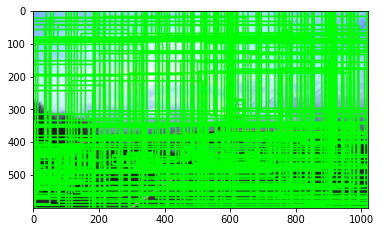

In [ ]:
counter = 0
for filename in test_images:
    aux = test_images.get(filename)[0].copy()
    txt_filename = open('mAP/input/detection-results/' + filename[-9:-4:] + '.txt', 'r')
    f = open(txt_filename.name, "r")
    # Draw predictions
    for line in f.readlines():
        chunks = line.split(' ')
        class_id, confidence = int(chunks[0]), float(chunks[1])
        bb_left, bb_top, bb_right, bb_bottom = float(chunks[2]), float(chunks[3]), float(chunks[4]), float(chunks[5])
        cv2.rectangle(aux, (int(bb_left), int(bb_top)), (int(bb_right), int(bb_bottom)), (0,255,0), 3)
    f.close()
    
    # Draw ground truth
    if filename in test_files:
        for idx in [i for i, x in enumerate(test_files) if x == filename]:
            bbox = test_bboxes[idx]
            cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (255,0,0), 3)
    plt.imshow(cv2.cvtColor(aux, cv2.COLOR_BGR2RGB))
    plt.show()
    counter += 1
    if counter < 10:
        break

In [ ]:
# Follow previous mAP code in order to evaluate the performance of your neural net
%cd -q mAP
%run main.py -na -np
%cd -q ..

3.30% = 1 AP 
0.94% = 10 AP 
4.66% = 11 AP 
1.46% = 12 AP 
15.51% = 13 AP 
59.62% = 14 AP 
0.37% = 15 AP 
0.00% = 16 AP 
54.17% = 17 AP 
0.14% = 18 AP 
12.95% = 2 AP 
0.05% = 22 AP 
0.00% = 23 AP 
0.00% = 24 AP 
0.03% = 25 AP 
0.00% = 26 AP 
0.00% = 28 AP 
0.00% = 29 AP 
0.15% = 3 AP 
0.00% = 30 AP 
0.00% = 31 AP 
0.42% = 32 AP 
35.14% = 33 AP 
46.67% = 34 AP 
53.33% = 35 AP 
0.00% = 36 AP 
0.00% = 37 AP 
12.75% = 38 AP 
0.00% = 39 AP 
0.00% = 4 AP 
5.19% = 40 AP 
0.00% = 41 AP 
0.00% = 42 AP 
2.59% = 5 AP 
0.04% = 6 AP 
26.53% = 7 AP 
0.59% = 8 AP 
11.24% = 9 AP 
mAP = 9.15%


<Figure size 432x288 with 0 Axes>